In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, BatchNormalization, Dropout
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

%matplotlib inline
%load_ext pycodestyle_magic

Using TensorFlow backend.


The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [128]:
%%flake8
v1 = pd.read_csv('example_data_new/v1_obfs.csv')
v2 = pd.read_csv('example_data_new/v2_obfs.csv')
v4 = pd.read_csv('example_data_new/v4_obfs.csv')
v8 = pd.read_csv('example_data_new/v8_obfs.csv')

In [132]:
%%flake8
v = [v1, v2, v4, v8]
v_names = ['v1', 'v2', 'v4', 'v8', 'v11', 'v14', 'v15', 'v19']
sel_columns = [' Meas_5', ' Meas_6', ' Meas_7', ' Meas_8', ' Meas_9', ' Meas_10']
sel_column = [' Meas_5']

4:80: E501 line too long (81 > 79 characters)


### Functions

In [211]:
def sliding_window(data, global_start, line_size, step_size):
    '''sliding window with an intersection between windows
    by size of _step_size_'''
    x, y = [], []
    for start in range(global_start, line_size, step_size):
        stop = start + train_test_size
        if stop <= line_size:
            x.append(data[start: start+train_size])
            y.append(data[start+train_size: start+train_size+test_size])
    return np.array(x), np.array(y)


def norm_ts(data):
    """
    scaler ->  TS∈[0,1] .
    """
    scaler = MinMaxScaler(copy=True)
    
    scaled01 = scaler.fit_transform(data)
    return np.squeeze(scaled01), scaler


def inverse_norm(data, scaler):
    """ inverse scaling
    """
    return scaler.inverse_transform(data)


def train_test_reshape(train_x, test_x):
    """reshape + split train test 50-50"""
    return np.expand_dims(train_x, axis=2), np.expand_dims(test_x, axis=2)


def naive_prediction_mae(x_test=test_x, y_test=test_y):
    naive_pred = 0
    n = x_test.shape[0]
    for i in range(n): 
        naive_pred += np.mean(np.abs(x_test[i, -1] - y_test[i, :]))
    naive_pred /= n
    print ('naive model = {0:0.4f}'.format(naive_pred))
    return None

def model_mae(model, x_test=test_x, y_test=test_y):
    y_pred = model.predict(x_test)
    mae = 0
    n = x_test.shape[0]
    for i in range(n): 
        mae += np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
    mae /= n
    print ('current model = {0:0.4f}'.format(mae))
    return None


In [247]:
train_size = 168
test_size = 24
train_test_size = train_size + test_size
line_size = v1.shape[1]
step_size = 2



### Normalization

In [248]:
data_normed, scaler = norm_ts(v1[sel_column].values)
train_test_split = int(.75 * v1.shape[0])

train_x, train_y = sliding_window(data=data_normed,
                                  global_start=0,
                                  line_size=train_test_split,
                                  step_size=step_size)

test_x, test_y = sliding_window(data=data_normed,
                                global_start=train_test_split+1,
                                line_size=v1.shape[0],
                                step_size=step_size)

train_x, test_x = train_test_reshape(train_x, test_x)
print (train_x.shape, test_x.shape)

(3187, 168, 1) (999, 168, 1)


### CNN network

In [249]:

def cnn_model(x_train, y_train, batch_size, epochs=50, n_steps_for_train=168):
    
    
    input_dim = n_steps_for_train
    model = Sequential()
    model.add(Convolution1D(filters=6, kernel_size=4, input_shape=(input_dim ,1)))
    model.add(Flatten())
    model.add(Dense(units=64, kernel_initializer='normal'))
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(units=60, actiivation='relu'))
    # model.add(Dense(units=40, activation='relu'))
    model.add(Dense(units=24, activation='linear'))


    sgd = optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error',
                  optimizer='sgd',
                  metrics=['mae'])

    history = model.fit(x_train, y_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_split=.3, verbose=2)
    return model, history

In [250]:
model, history = cnn_model(x_train=train_x, y_train=train_y, batch_size=4, epochs=20)

Train on 2230 samples, validate on 957 samples
Epoch 1/20
 - 1s - loss: 0.0282 - mean_absolute_error: 0.1108 - val_loss: 0.0162 - val_mean_absolute_error: 0.0803
Epoch 2/20
 - 1s - loss: 0.0169 - mean_absolute_error: 0.0870 - val_loss: 0.0137 - val_mean_absolute_error: 0.0770
Epoch 3/20
 - 1s - loss: 0.0146 - mean_absolute_error: 0.0814 - val_loss: 0.0124 - val_mean_absolute_error: 0.0727
Epoch 4/20
 - 1s - loss: 0.0133 - mean_absolute_error: 0.0776 - val_loss: 0.0117 - val_mean_absolute_error: 0.0699
Epoch 5/20
 - 1s - loss: 0.0124 - mean_absolute_error: 0.0744 - val_loss: 0.0110 - val_mean_absolute_error: 0.0669
Epoch 6/20
 - 1s - loss: 0.0116 - mean_absolute_error: 0.0717 - val_loss: 0.0105 - val_mean_absolute_error: 0.0646
Epoch 7/20
 - 1s - loss: 0.0110 - mean_absolute_error: 0.0692 - val_loss: 0.0101 - val_mean_absolute_error: 0.0630
Epoch 8/20
 - 1s - loss: 0.0104 - mean_absolute_error: 0.0670 - val_loss: 0.0098 - val_mean_absolute_error: 0.0619
Epoch 9/20
 - 1s - loss: 0.0098 -

In [251]:
train_x.shape, train_y.shape

((3187, 168, 1), (3187, 24))

### Comparison to Naive model

In [252]:
naive_prediction_mae()
model_mae(model)


naive model = 0.0576
current model = 0.0302


In [253]:
np.random.

SyntaxError: invalid syntax (<ipython-input-253-1a778a4e80a5>, line 1)

In [254]:
test_x.shape

(999, 168, 1)

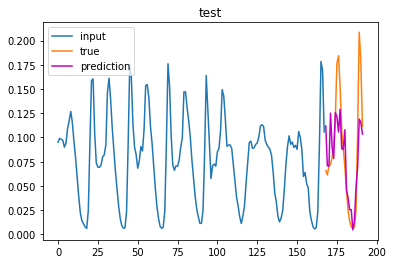

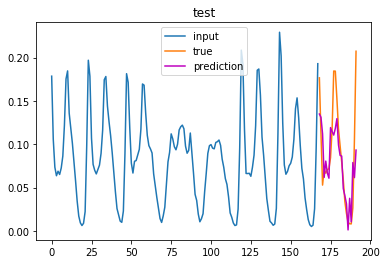

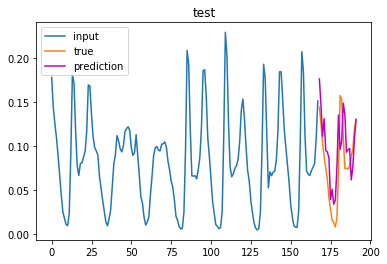

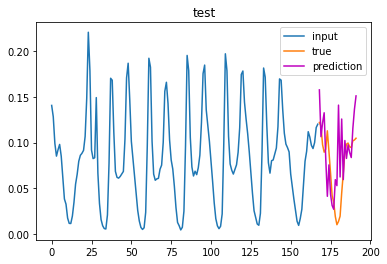

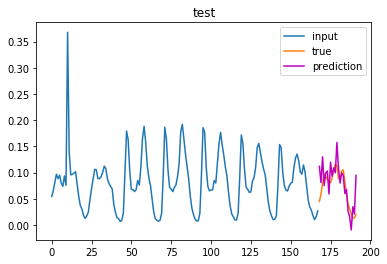

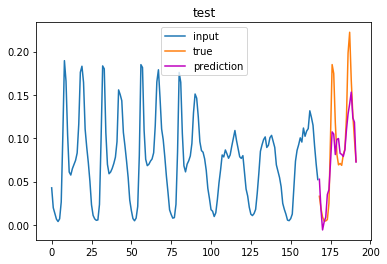

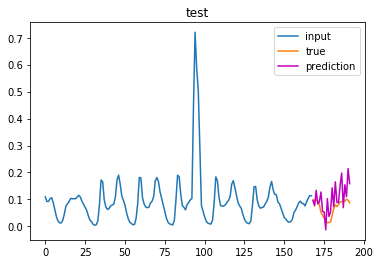

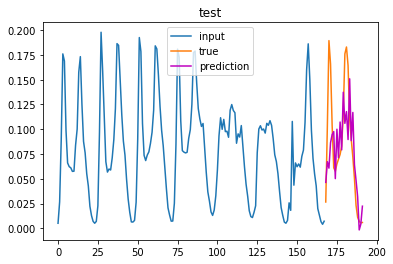

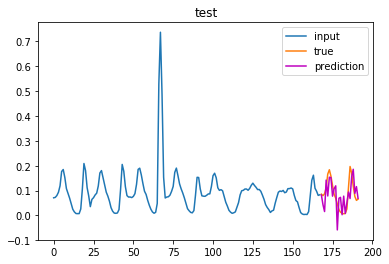

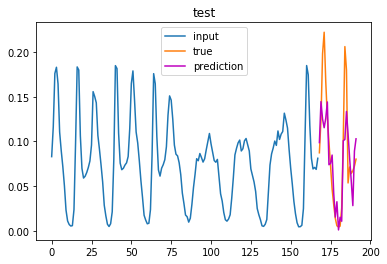

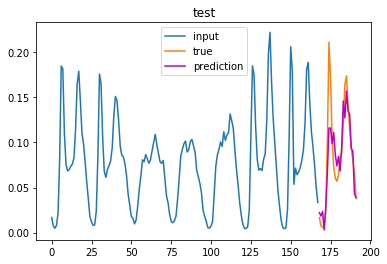

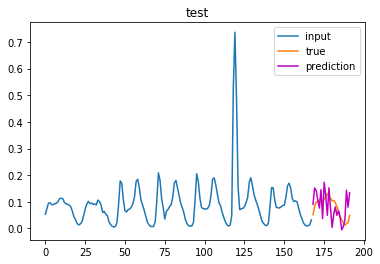

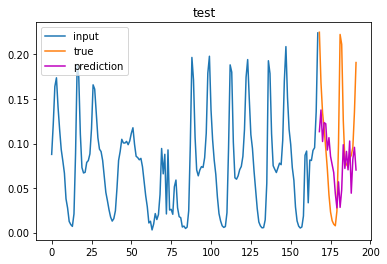

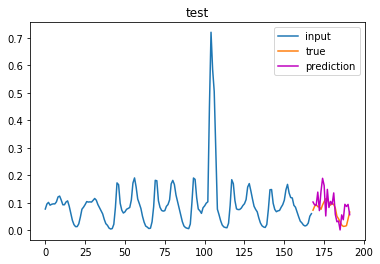

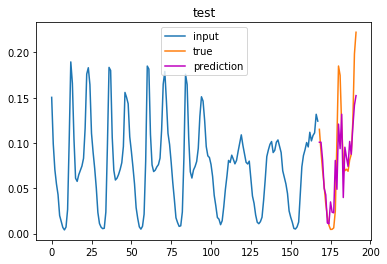

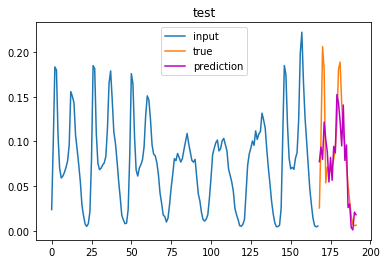

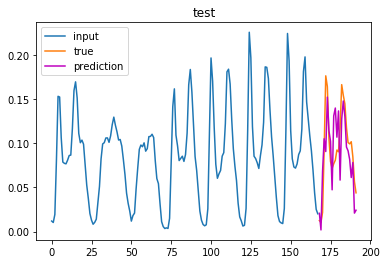

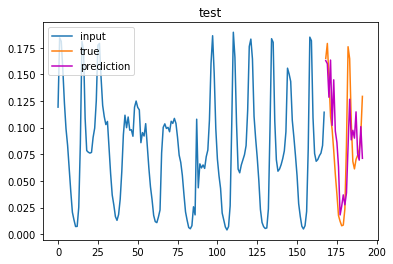

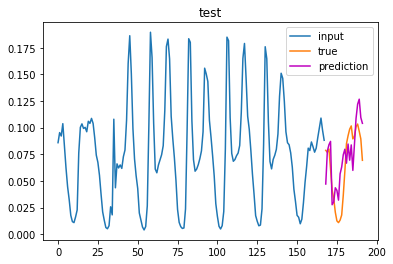

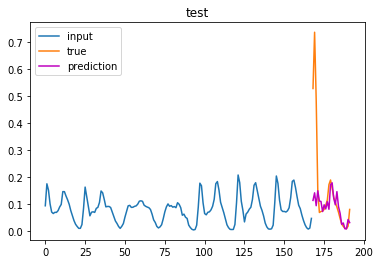

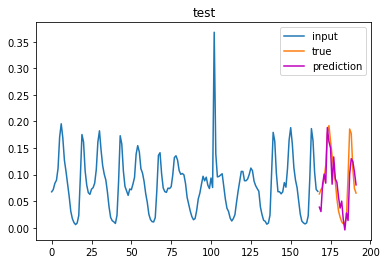

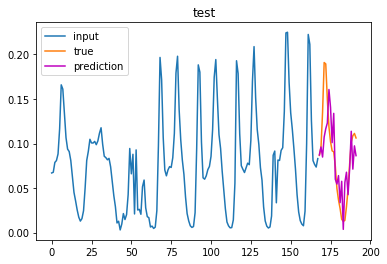

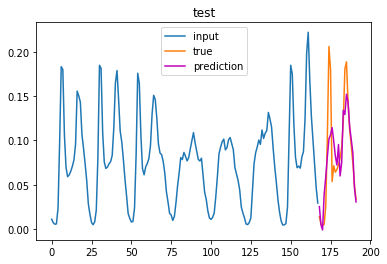

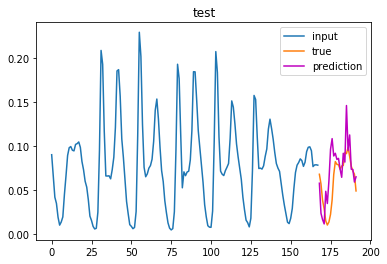

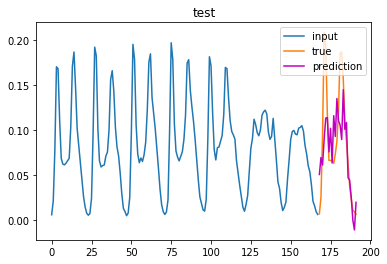

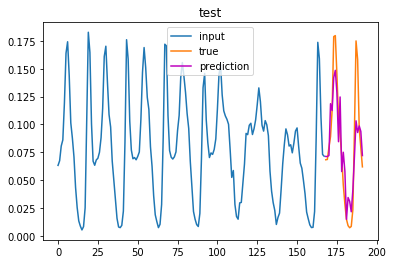

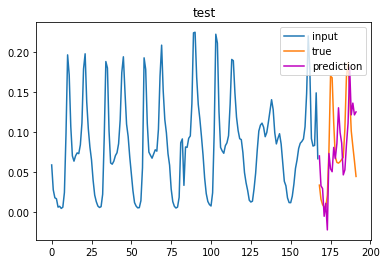

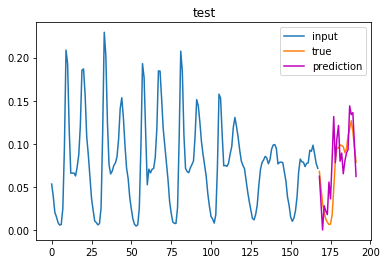

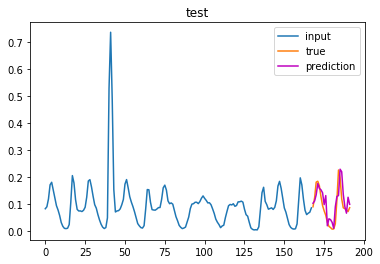

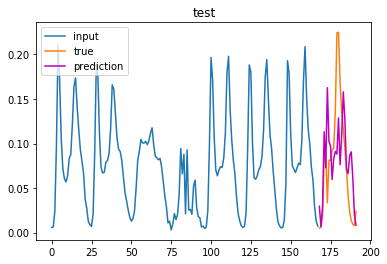

In [262]:
plt.rcParams.update({'figure.max_open_warning': 50})
np.random.seed(seed=123)
pred = model.predict(test_x)
for i in np.random.randint(0, test_x.shape[0], 30):
    plt.figure()
    plt.plot(range(168), test_x[i], label='input')
    plt.plot(range(168, 168+24), test_y[i], label='true')
    plt.plot(range(168, 168+24), pred[i], c='m', label='prediction')
    plt.title('test')
    plt.legend()

In [236]:

np.random.seed(seed=123)
np.random.randint(0, test_x.shape[0], 30)

array([510, 365, 382, 322,  98,  17, 595, 106, 123, 569, 214,  96, 113,
       638,  47,  73, 544, 224, 111, 409, 339, 253, 420, 608, 208,  68,
       451,   2, 340,  39])

In [260]:
list(range(0,30,3))

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]